# Tutorial del Framework Gymnasium y Herramientas de Trabajo proporcionadas por la cátedra

Importamos la biblioteca Gymnassium, que vamos a usar como framework de RL

In [2]:
!pip3 install cmake gymnasium scipy
import gymnasium as gym

Creamos un ambiente y lo mostramos en pantalla. Para esto definimos una función para imprimir nuestro ambiente.

In [3]:
# La semilla usada para crear el ambiente
semilla = 1

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

# Una funcion de ayuda para imprimir el estado de nuestro mundo
def print_env(estado):
  env_str = estado.render()
  print(env_str.strip())

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



El rectángulo de color representa el taxi, amarillo cuando va sin pasajero y verde con pasajero.
'|' representa una pared que el taxi no puede cruzar, es decir.
R, G, Y, B son los puntos de interés, es decir, las posibles ubicaciones de recogida y destino. La letra azul representa la ubicación actual de recogida de pasajeros, y la letra púrpura es el destino actual.

Si cambiamos la semilla, cambia el estado del ambiente.

In [4]:
# Una semilla diferente
semilla = 2

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Exploremos el espacio de estados y de acciones:

In [5]:
print(f"Espacio de Acciones {entorno.action_space}")
print(f"Espacio de Estados {entorno.observation_space}")

Espacio de Acciones Discrete(6)
Espacio de Estados Discrete(500)


Hay 6 acciones, que corresponden a:
 * 0 = ir al Sur
 * 1 = ir al Norte
 * 2 = ir al Este
 * 3 = ir al Oeste
 * 4 = recoger pasajero
 * 5 = dejar pasajero

Los puntos cardinales siguen la convención Norte hacia arriba. Recoger/dejar al pasajero solo tienen efecto si el taxi está en la misma casilla que el pasajero, y en uno de los puntos de interés.

Nuestro agente deberá elegir la acción a tomar en cada paso. Gymnassium nos expone funciones para esto. Si queremos movernos al sur, por ejemplo:

In [6]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)
print_env(entorno)
print()

accion = 0 # Sur
entorno.step(accion)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


Ahora estamos listos para programar un agente. Empezando por uno random. Se puede ejecutar el codigo abajo varias veces para ver como cambia en cada ejecución.

In [7]:
import random 

def episodio_random(semilla_ambiente = 1):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env
    entorno.reset(seed = semilla_ambiente)

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # para la animación

    termino = False
    truncado = False

    while not termino and not truncado:
        #  selecciona una acción aleatoria del conjunto de todas las posibles acciones
        accion = entorno.action_space.sample() 
        estado, recompensa, termino, truncado, info = entorno.step(accion)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        iteraciones += 1


    print(f"Iteraciones: {iteraciones}")
    print(f"Penalizaciones: {penalizaciones}")

    return marcos

marcos = episodio_random()

Iteraciones: 1222
Penalizaciones: 377


Podemos ver el episodio completo abajo. Notar que seleccionamos la semillia de selector de acciones para que la corrida sea 'buena'.

In [8]:
from IPython.display import clear_output
from time import sleep
import sys

def print_frames(marcos, delay=0.01):
    for i, marco in enumerate(marcos):
        clear_output()
        print(marco['marco'])
        print(f"Iteracion: {i + 1}")
        print(f"Estado: {marco['estado']}")
        print(f"Accion: {marco['accion']}")
        print(f"Recompensa: {marco['recompensa']}")
        sys.stdout.flush()
        # Aumentar este tiempo para ver mejor la animación
        sleep(delay)

print_frames(marcos)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iteracion: 1222
Estado: 0
Accion: 5
Recompensa: 20


Ahora queremos programar un agente inteligente, para eso nos vamos a atener a la siguiente interfaz.

In [9]:
class Agente:
    def elegir_accion(self, estado, max_accion) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones"""
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
        """
        pass

Para nuestro agente aleatorio, esto sería:

In [10]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # No aprende
        pass

Poniendolo a jugar:

In [11]:
import pdb
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env

agente = AgenteAleatorio()

iteraciones = 0
penalizaciones, recompensa = 0, 0

marcos = [] # for animation

termino = False
truncado = False
estado_anterior, info = entorno.reset(seed = semilla)
while not termino and not truncado:
    # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
    accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)

    # Realizamos la accion
    estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)

    # Le informamos al agente para que aprenda
    agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

    # El agente trato de dejar/recoger al pasajero incorrectamente
    if recompensa == -10:
        penalizaciones += 1

    # Put each rendered frame into dict for animation
    marcos.append({
        'marco': entorno.render(),
        'estado': estado_siguiente,
        'accion': accion,
        'recompensa': recompensa
        }
    )

    estado_anterior = estado_siguiente
    iteraciones += 1

print(f"Iteraciones: {iteraciones}")
print(f"Penalizaciones: {penalizaciones}")

Iteraciones: 3394
Penalizaciones: 1048


Podemos encapsular lo anterior en una función 

In [12]:
def ejecutar_episodio(agente, semilla):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # for animation

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed = semilla)
    while not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado_siguiente,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        estado_anterior = estado_siguiente
        iteraciones += 1
        
    return iteraciones, penalizaciones, marcos


y correrlo varias veces para ver el rendimiento promedio

In [13]:
agente = AgenteAleatorio()
semilla = 1
num_iteraciones_episodios = []

for i in range(10):
    num_iteraciones, _, _ = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]

Y obtener métricas al respecto

In [14]:
import numpy
import random

print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)} iteraciones, en promedio")

Se realizaron 1739.6 iteraciones, en promedio


# Entrega 3, Grupo 02 - Aprendizaje por Refuerzos

| Nombre           | C.I     | Email                        |
|----------------|-----------|------------------------------|
| Santiago Alaniz| 5082647-6 | santiago.alaniz@fing.edu.uy  |
| Bruno De Simone| 4914555-0 | bruno.de.simone@fing.edu.uy  |
| María Usuca    | 4891124-3 | maria.usuca@fing.edu.uy      |


## Introducción


El ambiente donde nuestro agente aprende es definido por el framework de RL `gymnasium`, concretamente el ambiente `taxi-v3`. 

Despues de leer la seccion anterior y la [documentación del framework](https://gymnasium.farama.org/environments/toy_text/taxi/), listamos las siguientes observaciones relevantes.

### Codificación y representación de estados

En el curso vimos que una forma de representar el ambiente es mediante cadenas de Markov, donde cada estado es un nodo y cada acción es una transición entre nodos (con una función de recompensa asociada a la arista que los comunica). En este caso, la cantidad de estados es 500, y la cantidad de acciones es 6.

Los estados se indexan segun la siguiente fórmula:

```
((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
```

Entonces, para cada estado, se codifica la información de las paradas origen/destino. Nuestro agente, que va a utilizar el algoritmo de Q learning, debe actualizar valores en una matriz Q de 500x6, donde cada fila representa un estado y cada columna una accion. 

### Representación conceptual del ambiente

El ambiente es un conjunto de cadenas markovianas disconexas identificadas principalmente por el par de paradas (origen, destino), otros factores que aportan son:

- la ubicación del pasajero en el mapa, que puede ser en el taxi o en una de las paradas
- posición del taxi en la grilla.

Por ejemplo, consideremos un estado `Ei` de alguna de las cadenas markovianas disjuntas. Este estado tiene codificado en su numero identificador:
- Un par de paradas (origen, destino).
- Una ubicación del pasajero, representado supongamos por un booleano, 0 si esta en el taxi, 1 si esta en alguna parada.
- Una ubicación del taxi en la grilla.

El estado `Ei` tiene 6 acciones posibles, podemos afirmar que para cada acción tomada el estado resultante `Ej` tiene codificado en su numero identificador:
- El mismo par de paradas (origen, destino), si no es el estado final.
- Una ubicación del pasajero, 0 si esta en el taxi, 1 si esta en la parada origen. Si la acción es recoger/dejar pasajero, este valor podría cambiar.
- Una ubicación del taxi en la grilla que puede ser nueva si la acción es alguna de las 4 posibles de movimiento.

<br>
  <p align="center">
    <img width="400" src="img/diagrama-ubicacion-pasajero.png"/>
  </p>
<br>

<br>
  <p align="center">
    <img width="400" src="img/diagrama-destinos.png"/>
  </p>
<br>


## Parte 1

Programar las funciones de la clase `AgenteRL`, manteniendo cualquier función adicional necesaria en la misma clase.

### **Clase `AgenteRL`**

Esta implementación está fuertemente inspirada en los conceptos presentados en el libro de Mitchell, *Machine Learning* (1997) y las clases impartidas por el equipo docente.

El agente interactúa con un entorno provisto por el cuerpo docente, donde debemos mover un taxi en un mapa para recoger y dejar pasajeros. El objetivo es que el taxi aprenda la política óptima, es decir, recoger y dejar al pasajero con la menor cantidad de pasos y con la menor cantidad de penalizaciones.

##### **Variables de instancia**:
- `self.gamma`: Un factor de descuento, generalmente denotado como gamma (`γ`), que determina cuánto valor le da el agente a las recompensas futuras en comparación con las inmediatas. Toma como valor constante `0.9`. A diferencia de `self.k` y `self.delta_t`, no cambia con el tiempo, aunque somos conscientes de que agentes más vanguardistas aplican técnicas de perfeccionamiento de este valor a lo largo del tiempo.

- `self.k`: Es el atributo pivotal que redefine la función de distribución `X_s_a` utilizada para elegir la "mejor" acción posible. `self.k` es la función creciente `f(x)` a lo largo de las iteraciones del episodio. Esto último es una decisión de diseño para beneficiar a la exploración en etapas iniciales. Queremos que el agente explore el entorno y no se quede estancado en un mínimo local, por lo que le damos más peso a la exploración en etapas iniciales, y a medida que el agente va aprendiendo, le damos más peso a la explotación.

- `self.Q`: Una tabla Q inicializada como una matriz de ceros. Las dimensiones de la matriz dependen del número de estados (`entorno.observation_space.n`) y el número de acciones (`entorno.action_space.n`) en el entorno en el que se encuentra el agente, `(Q: 500x6)`.

##### **Métodos**:

- `__init__(self, entorno) -> None`: El constructor de la clase que inicializa las variables de instancia.

- `elegir_accion(self, estado, max_accion) -> int`: Define la función de distribución `X_s_a` para el valor de `self.K` actual. Luego, utilizando el metodo `np.random.choice` elige una acción con distribucion `X_s_a`.

- `aprender(self, estado_anterior, estado_siguiente, accion, recompensa)`: Este método actualiza la tabla Q utilizando la ecuación de actualización (Bellman), tambien incrementa el valor de `self.k` para que el agente empiece a preponderar la informacion recabada por sobre la exploracion.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Mitchell 97. Chapter 13
class AgenteRL(Agente):
    def __init__(self, entorno) -> None:
        self.gamma = 0.9
        self.k = 1
        self.Q = np.zeros((entorno.observation_space.n, entorno.action_space.n))
        # Metricas
        self.episodes_iter = []
        self.episodes_pen = []
        self.episodes_frames = []

    
    def elegir_accion(self, estado, max_accion) -> int:
        # Exploracion vs Explotacion, Mitchell 97. p.379
        aux = np.power(np.ones(max_accion) * self.k , self.Q[estado])
        X_s_a = aux / np.sum(aux)
        
        # Elegimos una accion con distribucion X_s_a
        return np.random.choice(max_accion, 1, p= X_s_a)[0]
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # Aumento k (factor de "confianza")
        self.k += 1
        
        # Actualizamos la tabla Q con la ecuacion de Bellman 
        Q_max_estado_siguiente = np.max(self.Q[estado_siguiente])
        self.Q[estado_anterior, accion] = recompensa + self.gamma * Q_max_estado_siguiente

### Métodos auxiliares para la presentacion de resultados.

- `metricas(iteraciones, penalizaciones)`: media y desviación estandar de las iteraciones y penalizaciones.
- `ver_episodio(frames, tiempo_total= 5)`: muestra el episodio en el entorno, con un tiempo de espera entre frames de `tiempo_total` segundos.
- `dibujar_subgrafico(**args)`: dibuja un subgráfico con los parámetros pasados por argumento.

In [16]:
# Funciones auxiliares

def metricas(agente: AgenteRL):
  print(f"\
[{agente.__class__.__name__}]\n\
  [ITERACIONES]       mean: {np.mean(agente.episodes_iter)}, std: {np.std(agente.episodes_iter)}\n\
  [PENALIZACIONES]    mean: {np.mean(agente.episodes_pen)}, std: {np.std(agente.episodes_pen)}\n\
  ")


def ver_episodio(marcos, tiempo_total= 5): print_frames(marcos, delay= tiempo_total/len(marcos))
  
def dibujar_subgrafico(episodios, datos, subindice, etiqueta_y, titulo, color='blue', escala_log_x=False, escala_log_y=False):
    plt.subplot(3, 1, subindice)
    plt.plot(episodios, datos, color=color)
    
    plt.xlabel('Episodio')
    plt.ylabel(etiqueta_y)
    plt.title(titulo)
    
    if escala_log_x: plt.xscale('log')
    if escala_log_y: plt.yscale('log')

    plt.grid(True)

def comparar_agentes(agente_a: AgenteRL, agente_b: AgenteRL):
    iter_a = np.array(agente_a.episodes_iter)
    iter_b = np.array(agente_b.episodes_iter)

    comparative = np.where(iter_a < iter_b)
    comparative_comp = np.where(iter_a >= iter_b)

    metricas(agente_a)
    metricas(agente_b)

    print(f"{agente_a.__class__.__name__} >> {agente_b.__class__.__name__} : {100*len(comparative[0]) / len(iter_a)} %")
    print(f"{agente_a.__class__.__name__} << {agente_b.__class__.__name__} : {100*len(comparative_comp[0]) / len(iter_a)} %")

    _index = [i for i in range(0, len(agente_a.episodes_iter))]

    plt.figure(figsize=(8, 12))

    dibujar_subgrafico(
    _index, 
    agente_a.episodes_iter, 
    1, 
    'Iteraciones', 
    agente_a.__class__.__name__ + " Iteraciones por episodio (escala logarítmica y)",
    escala_log_y=True
    )

    dibujar_subgrafico(
    _index, 
    agente_b.episodes_iter, 
    2, 
    'Iteraciones', 
    agente_b.__class__.__name__ + " Iteraciones por episodio (escala logarítmica y)",
    escala_log_y=True
    )

    plt.subplots_adjust(hspace=0.5)
    plt.show()

## Parte 2

Analizar los resultados de una ejecución de mil episodios con el agente programado. Agregar un nuevo bloque de de texto discutiendo los resultados obtenidos

[AgenteRL]
  [ITERACIONES]       mean: 14.104, std: 31.241209707692185
  [PENALIZACIONES]    mean: 0.138, std: 3.153245312372634
  


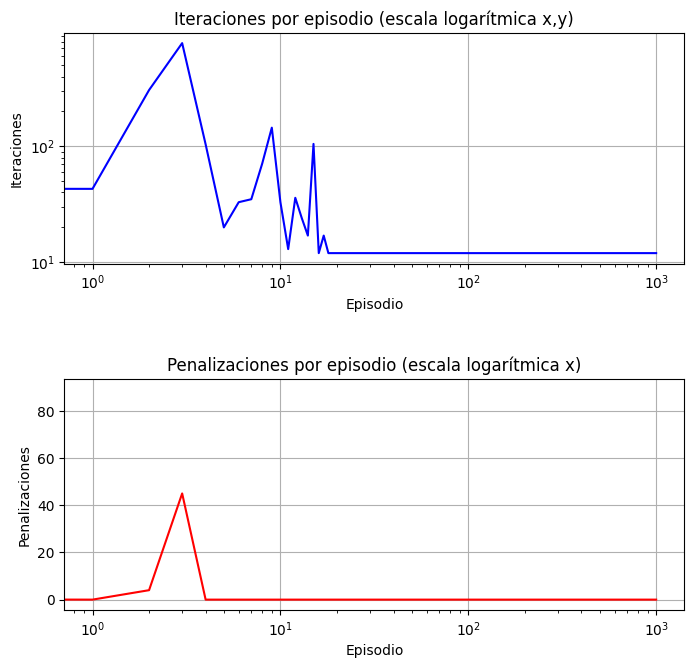

In [17]:
agente_1 = AgenteRL(entorno)
semilla = 1

for i in range(1000):
    num_iteraciones, penalizaciones, marcos = ejecutar_episodio(agente_1, semilla)
    agente_1.episodes_iter += [num_iteraciones]
    agente_1.episodes_pen += [penalizaciones]
    agente_1.episodes_frames += [marcos]

metricas(agente_1)

plt.figure(figsize=(8, 12))

_index = [i for i in range(0, len(agente_1.episodes_iter))]

dibujar_subgrafico(
  _index, 
  agente_1.episodes_iter, 
  1, 
  'Iteraciones', 
  'Iteraciones por episodio (escala logarítmica x,y)', 
  escala_log_x=True, 
  escala_log_y=True
)

dibujar_subgrafico(
  _index,
  agente_1.episodes_pen,
  2,
  'Penalizaciones',
  'Penalizaciones por episodio (escala logarítmica x)',
  escala_log_x=True,
  color='red',
)

plt.subplots_adjust(hspace=0.5)
plt.show()

### Análisis de resultados

En nuestro algoritmo, hemos implementado una **estrategia de exploración que evoluciona a lo largo del tiempo**, lo que ha demostrado ser efectivo en el proceso de aprendizaje por refuerzo. Inicialmente, favorecemos la exploración, al ponderar la selección de acciones en función del conocimiento actual del agente y variando el parámetro `k` con el número de iteraciones. Esto permite al agente realizar exploración intensiva al principio y luego cambiar gradualmente hacia la explotación de conocimientos adquiridos. 

Los vestigios de exploración se pueden ver en los "picos" iniciales en la cantidad de iteraciones por episodio, esto da cuenta de la exploración intensiva que realiza el agente al principio. A medida que el agente acumula conocimiento sobre el entorno, la cantidad de iteraciones por episodio disminuye, llegado a un punto en el tiempo donde el agente se vuelve más eficiente en su toma de decisiones y la cantidad de iteraciones por episodio se estabiliza, que además coincide con la convergencia de la política óptima.

En nuestros resultados se puede observar que la **cantidad de penalizaciones disminuye** a medida que aumenta el número de episodios. Este comportamiento es esperado, ya que el agente va acumulando conocimiento sobre el entorno y aprende a evitar las acciones que conllevan penalizaciones. Además, el agente se vuelve más eficiente en su toma de decisiones, lo que se refleja en una disminución en la cantidad de iteraciones necesarias para alcanzar su objetivo.

En **comparación con el agente aleatorio**, el agente de aprendizaje por refuerzo logra reducir considerablemente la cantidad de iteraciones requeridas para alcanzar sus objetivos. Esto subraya la eficacia del aprendizaje por refuerzo en la mejora del desempeño del agente y su capacidad para tomar decisiones más informadas a lo largo del tiempo.

Para poder apreciar mejor la evolución del agente, se puede ejecutar el siguiente código que muestra una serie de episodios de interés.

*Nota*:

A lo largo del laboratorio la definición de un `self.k` lo "suficientemente bueno" para que el agente aprenda fue un problema. Encontramos que un `self.k` que crece linealmente con el tiempo es una buena solución. Sin embargo,exploramos los límites de esta técnica.

Por ejemplo, si definimos `self.k` como una función constante, el agente no logra converger a la política óptima. Si `self.k = 1` la distribución es exactamente equiprobable, es decir es el agente aleatorio. Pero el otro componente de la distribución es la tabla Q, que se actualiza con la ecuación de Bellman. Si `self.k = 1` entonces la tabla Q no se actualiza, y el agente no aprende. Si `self.k > 1` y `self.Q[accion]` es lo suficientemente grande, la distribución sera preponderante para esa acción.

Entonces, queremos un `self.k` que crezca a medida que el agente "aprende", a nuestro juicio, es correcto afirmar que a medida que las iteraciones aumentan, el agente conoce más. Por lo tanto, `self.k` debe crecer en función de las iteraciones de cada episodio

- `self.k` lineal: convergencia para todos los casos observados
- `self.k` logarítmico: convergencia para algunos casos observados
- `self.k` constante: convergencia para algunos casos observados

La conclusión es que `self.k` debe crecer con el tiempo, y que ese orden debe ser lineal o mayor.

In [18]:
# Ver alguno de los episodios
ver_episodio(agente_1.episodes_frames[13])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iteracion: 24
Estado: 0
Accion: 5
Recompensa: 20


## Parte 3

Ejecutar 1000 episodios con una semilla diferente y analizar los resultados. Agregar un nuevo bloque de texto discutiendo los resultados obtenidos.

### Metodología

Tomando la siguiente proporción de ejecuciones, realizamos el siguiente experimento:

- 60% con la misma semilla (SI). Para cada una de las variantes
  - 40% con una semilla alternativa (SA) que difiera solo en la posición del taxi.
  - 40% con una semilla alternativa (SA) que difiera en la posición del taxi y en la posición del destino.
  - 40% con una semilla alternativa (SA) que difiera en todo.

Es decir, tres subexperimentos, cada uno con 60% de ejecuciones con la misma semilla, y 40% de ejecuciones con una semilla alternativa, cada una genera un entorno más disrupitivo que la anterior.

In [19]:
metodologia = {
  'taxi': (1, 9),
  'taxi_destino': (1, 18),
  'taxi_origen_destino': (1, 7),
}

for metodo in metodologia.items():
  print(f"Metodologia: {metodo[0]}")
  for seed in metodo[1]:
    entorno.reset(seed = seed)
    print(f'SEED {seed}')
    print_env(entorno)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

Metodologia: taxi
SEED 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
SEED 9
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Metodologia: taxi_destino
SEED 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
SEED 18
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Metodologia: taxi_origen_destino
SEED 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
SEED 7
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Metodologia: taxi
[AgenteRL]
  [ITERACIONES]       mean: 15.595, std: 35.82832643314504
  [PENALIZACIONES]    mean: 0.193, std: 4.3210821561270985
  


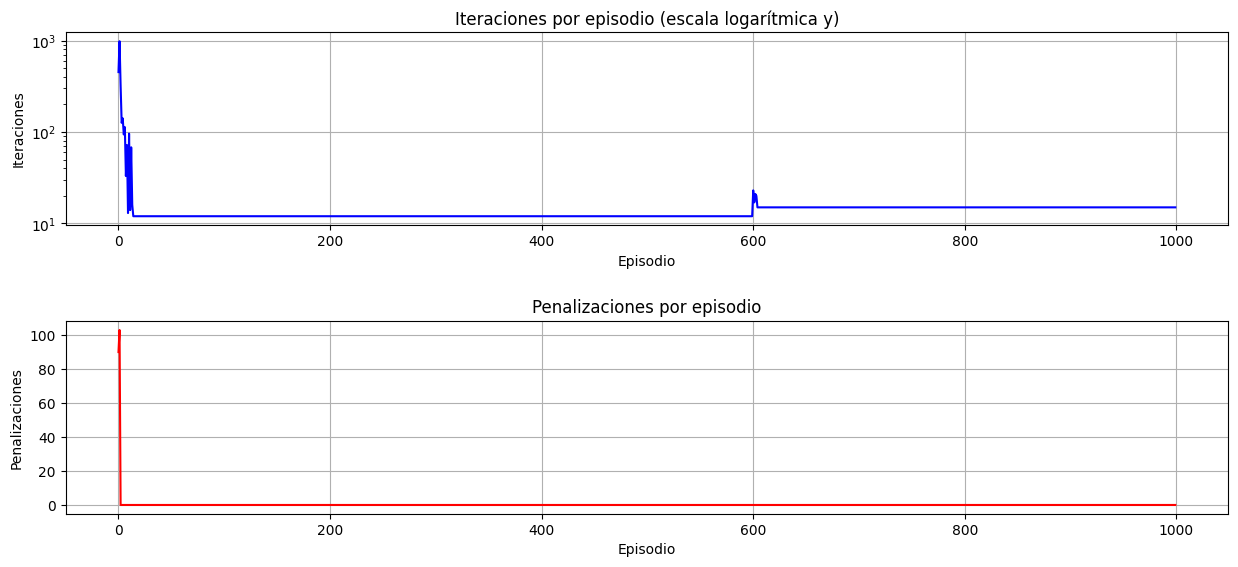

Metodologia: taxi_destino
[AgenteRL]
  [ITERACIONES]       mean: 16.945, std: 50.8305811003573
  [PENALIZACIONES]    mean: 0.332, std: 6.819074423996264
  


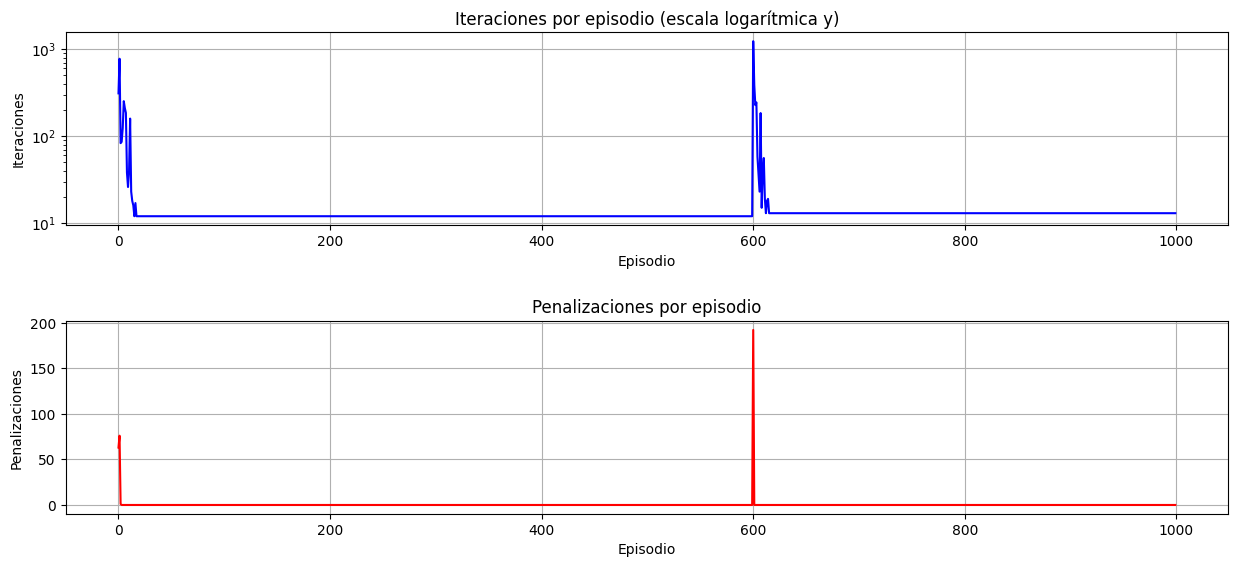

Metodologia: taxi_origen_destino
[AgenteRL]
  [ITERACIONES]       mean: 16.387, std: 52.90675978549434
  [PENALIZACIONES]    mean: 0.332, std: 6.1505915162689835
  


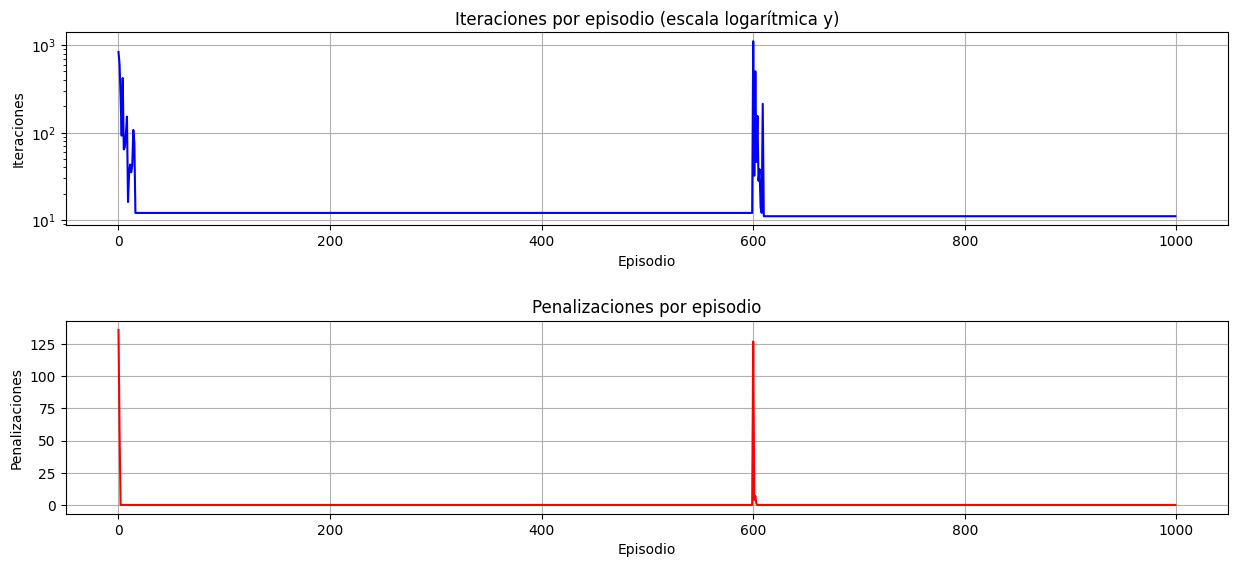

In [20]:
for metodo in metodologia.items():
  agente_1 = AgenteRL(entorno)
  num_iteraciones_episodios = []
  num_penalizaciones_episodios = []
  
  for i in range(600):
    entorno.reset(seed = metodo[1][0])
    num_iteraciones, penalizaciones, _ = ejecutar_episodio(agente_1, metodo[1][0])
    agente_1.episodes_iter += [num_iteraciones]
    agente_1.episodes_pen += [penalizaciones]
  
  for i in range(400):
    num_iteraciones, penalizaciones, _ = ejecutar_episodio(agente_1, metodo[1][1])
    agente_1.episodes_iter += [num_iteraciones]
    agente_1.episodes_pen += [penalizaciones]
  
  print(f"Metodologia: {metodo[0]}")
  metricas(agente_1)

  _index = [i for i in range(0, len(agente_1.episodes_iter))]
  plt.figure(figsize=(15,10))

  dibujar_subgrafico(
    _index, 
    agente_1.episodes_iter, 
    1, 
    'Iteraciones', 
    'Iteraciones por episodio (escala logarítmica y)',
    escala_log_y=True
  )

  dibujar_subgrafico(
    _index,
    agente_1.episodes_pen,
    2,
    'Penalizaciones',
    'Penalizaciones por episodio',
    color='red',
  )

  plt.subplots_adjust(hspace=0.5)
  plt.show()

### Análisis de resultados

El agente sobreaprende un entorno, al cambiar la semilla, este cambia y el agente tiene que readaptarse. Esto se ve reflejado en la cantidad de iteraciones por episodio y la cantidad de penalizaciones.

Además, como también intuíamos, el agente se comporta mejor mientras más parecido sea el entorno al que aprendió.

En particular, cuando solo cambia la posición del taxi no sufre penalizaciones, aunque hay un aumento marginal en las iteraciones para luego converger rápidamente, dado que el binomio origen/destino es el mismo.

Cuando ya cambia una de las posiciones de origen/destino, el agente sufre penalizaciones e iteraciones de forma similar al principio, tiene sentido ya que al cambiar una de las posiciones, se reconfigura totalmente el problema a resolver.

No hay diferencias significativas entre cambiar una o ambas paradas de origen/destino respecto al ambiente original, se comportan de forma similar.

## Parte 4

Realizar los cambios necesarios para que el agente sea capaz de tener un buen desempeño utilizando una semilla arbitraria, ejecutar iteraciones con semillas arbitrarias y analizar los resultados. Agregar un nuevo bloque de texto discutiendo los resultados obtenidos.

### Metodología.

En la parte anterior, vimos que el agente se comporta peor en entornos que difieren al entorno en el cual fue entrenado.

Lo que hace este experimento es profundizar en este concepto, analizar como se comporta el agente cuando iteración a iteración se cambia la semilla, es decir, el entorno. Y analizar si al final de la iteración, el agente es capaz de adaptarse a cualquier semilla.

Esquemáticamente, el experimento es el siguiente:

- Se define una semilla de evaluación
- Se define una semilla de entrenamiento 
- Se define un parámetro ciclos

Para las primeras 600 iteraciones:

- Se entrena el agente con una semilla x = semilla de entrenamiento + iteración

Para las últimas 400 iteraciones

- Se evalua el agente con una semilla x = semilla de evaluación + (iteracion % ciclos)

Es decir, en primera istancia, el agente se entrena con 600 semillas potencialmente diferentes entre si, para luego evaluarlo con semillas que se repiten cada `ciclos` iteraciones. El objetivo es ver si el agente puede sobreponerse a la variabilidad del entorno para luego independientemente de la semilla, tener un buen desempeño.

### Desempeño de nuestro agente `AgenteRL` en el experimento 

[AgenteRL]
  [ITERACIONES]       mean: 28.625, std: 72.34753883167001
  [PENALIZACIONES]    mean: 0.765, std: 8.518672138308881
  


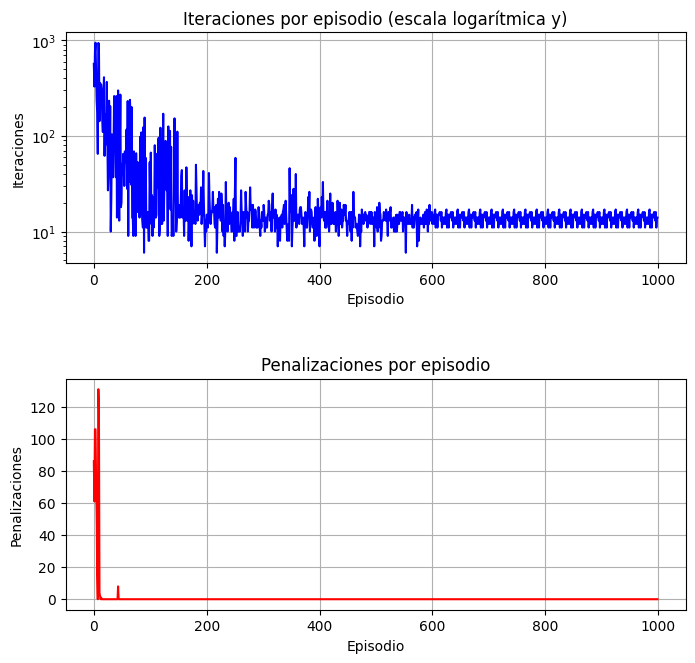

In [21]:
seed_train = 50826476
seed_test = 420
cicles = 20

agente_1 = AgenteRL(entorno)
num_iteraciones_episodios = []
num_penalizaciones_episodios = []
marcos_episodios = []

x = 0

for i in range(1000):
  if i < 600:
    x = seed_train + i
  else:
    x = seed_test + (i % cicles)
    
  num_iteraciones, penalizaciones, marcos = ejecutar_episodio(agente_1, x)
  agente_1.episodes_iter += [num_iteraciones]
  agente_1.episodes_pen += [penalizaciones]
  agente_1.episodes_frames += [marcos]

metricas(agente_1)

plt.figure(figsize=(8, 12))

_index = [i for i in range(0, len(agente_1.episodes_iter))]

dibujar_subgrafico(
  _index, 
  agente_1.episodes_iter, 
  1, 
  'Iteraciones', 
  'Iteraciones por episodio (escala logarítmica y)',
  escala_log_y=True
)

dibujar_subgrafico(
  _index,
  agente_1.episodes_pen,
  2,
  'Penalizaciones',
  'Penalizaciones por episodio',
  color='red',
)

plt.subplots_adjust(hspace=0.5)
plt.show()

Para nuestra implementación, el agente obviamente se comporta peor que en el experimento anterior, someterlo a un entorno diferente en cada iteración introduce ruido en el aprendizaje, haciendolo iterar más.

Este ciclo de experimentación intensiva se puede apreciar en la gráfica, más precisamente entre los episodios 0-100.

Pasado este ciclo, el agente logra identificar patrones en cada entorno y diferenciarlos de los demás, esto se ve en la reducción paulatina de iteraciones, las penalizaciones también son intensivas al principio, pero luego se anulan.

Ya entre los episodios 400-600 podemos inferir debido al número de iteraciones y penalizaciones que el agente esta dando la política óptima para cada entorno.

Lo que finalmente confirma nuestra sospecha es que a partir de la iteración 600, puede repetir el patrón definido por la `test_seed + (i % ciclos)`  para cada una de las 400 iteraciones restantes.

Consideramos que el fenómeno que se observa puede ser explicado por la siguiente razonamiento:
  - cada episodio nuevo, puede ser un entorno diferente al anterior, por lo tanto el agente tiene que aprender a adaptarse en ese entorno
  - sin embargo, como vimos en la `parte 3)`, el agente se comporta mejor en entornos que se parecen.
  - los entornos más dispares entre sí son los que tienen combinación de origen/destino diferentes `parte 3)`, por lo tanto el agente tiene que aprender a adaptarse a cada combinación de origen/destino
  - los entornos donde solo cambia la posición del taxi, el agente simplemente tiene que aprender el camino más corto, no sufre penalizaciones, dado que el binomio origen/destino es el mismo, el aumento de iteraciones existe, pero marginal en comparación con los otros casos.

Entonces, despreciando el escenario anterior, el problema se reduce a combinaciones origen/destino potencialmente diferentes en cada episodio. 
El número de pares únicos es `2 * C(4,2) = 12`, consideremos `P(x=par_i)`, la probabilidad de obtener el `par_i`. Asumiendo que gymnasium genera los pares de origen/destino de forma equiprobable, entonces P(x=par_i) = 1/12.

`E(P(x=par_i)) = 1/12`, si repetimos el experimento **600 veces**, esperamos ver la misma combinación (origen, destino) **50 veces**, lo cual es suficiente para aprender, como vimos anteriormente `parte 1)`, con la misma semilla, el agente converge a la politca óptima en la 10ma iteración. 

En resumen, el agente es capaz de adaptarse a cualquier entorno, pero requiere de un periodo de aprendizaje intensivo, con la certeza de que en cada iteración, la esperanza matemática lo favorece, y pueda ver escenarios similares. Hay que destacar también el peso que tiene la `definición de estados explicada en la parte 1)` en el aprendizaje del agente, ya que el agente no tiene que aprender a adaptarse a cada entorno, sino a cada combinación de origen/destino, que sabemos que se modelan con cadenas markovianas disconexas.


In [22]:
# Ver alguno de los episodios
ver_episodio(agente_1.episodes_frames[600])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iteracion: 12
Estado: 475
Accion: 5
Recompensa: 20


### Potenciales Mejoras

El agente `AgenteRL` es capaz de adaptarse a cualquier entorno, pero requiere de un periodo de aprendizaje intensivo de aproximadamente 100 episodios para luego poder identificar patrones en cada entorno y diferenciarlos de los demás. 

Este es el punto débil de nuestro agente, cualquier método alternativo que busque y logre reducir el periodo de aprendizaje intensivo, es una mejora potencial.

#### Caso de estudio: AgenteRL2 y su fracaso.

Consideramos incluir en este obligatorio la implementacion de un agente que **nunca funcionó mejor** que el agente `AgenteRL`, pero que nos permitió explorar algunas ideas y familiarizarnos con conceptos que nos ayudaron a entender mejor el problema (fue clave para la redacción de la introducción y todas las partes en general).

Aunque no pudimos rescatar ninguna heurística para mejorar al `AgenteRL` en términos de rendimiento. Consideramos que es importante incluirlo en este informe.

En primera instancia habiamos entendido que, el hecho de que el **experimento varia de semilla**, puede ser visto como un problema donde el agente vive en un entorno donde **la función de recompensa es probabilistica**, es decir, la tupla (estado, acción) tiene una recompensa modelada por una variable aleatoria.

Convenientemente, aunque también sesgados por querer aplicar conceptos del Mitchell. Al final del capítulo de `Reinforcement Learning`, se presenta un apartado denominado `Nondeterministic rewards and actions`, donde, intuíamos, habían conceptos que podían ser aplicados a este problema, obviamente, no fue así.

La sección presenta un algoritmo que permite al agente adaptarse a un entorno donde la función de recompensa es una variable aleatoria. 

Modifica la ecuación de Bellman para que el agente pueda ponderar (con un termino denominado `alpha`) la recompensa recibida, en base a la cantidad de veces que se ha visto dicha recompensa, es decir la tríada (estado, acción, recompensa).

El problema es que si bien el episodio cambia de semilla, y por lo tanto el ambiente, la naturaleza del mismo, generado por gymnassium, es, bajo ningún concepto, estocástico, la tupla (estado, acción) tiene siempre la misma recompensa **en todos los ambientes**, porque cada estado posible está debidamente identificado, así como cada acción posible (ver `parte 1)`).

Entonces, aplicar el algoritmo de la sección `Nondeterministic rewards and actions` es un error conceptual, porque el agente no tiene que aprender a adaptarse a una recommpensa estocástica, sino a un entorno que cambia/mantiene el par (destino, origen) en cada iteración del experimento, pero que es determinístico.

Fue un error de conceptos grave, pero nos permitió entender porque el agente `AgenteRL` funciona bien y abordar el problema desde una perspectiva más conceptual.

In [23]:
import numpy as np
import pdb

# Mitchell 97. Chapter 13
class AgenteRL2(AgenteRL):
    def __init__(self, entorno) -> None:
        super().__init__(entorno)
        self.visits = {}
    
    def elegir_accion(self, estado, max_accion) -> int:
        return super().elegir_accion(estado, max_accion)
        
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # Actualizamos la tabla Q con la ecuacion de Bellman 
        Q_max_estado_siguiente = np.max(self.Q[estado_siguiente])
        classic_update = recompensa + self.gamma * Q_max_estado_siguiente
        tupla = (estado_anterior, accion, recompensa)
        
        self.visits.setdefault(tupla, 0)
        self.visits[tupla] += 1
        
        # Facr de confianza, definido en funcion de las visitas a la tupla
        self.k += 1
        
        alpha_n =  1 / (1 + self.visits[tupla])
        
        self.Q[estado_anterior, accion] = (1 - alpha_n) * self.Q[estado_anterior, accion] + \
                                          (alpha_n) * classic_update

[AgenteRL2]
  [ITERACIONES]       mean: 143.37, std: 152.66225171927735
  [PENALIZACIONES]    mean: 0.769, std: 8.517372775686171
  


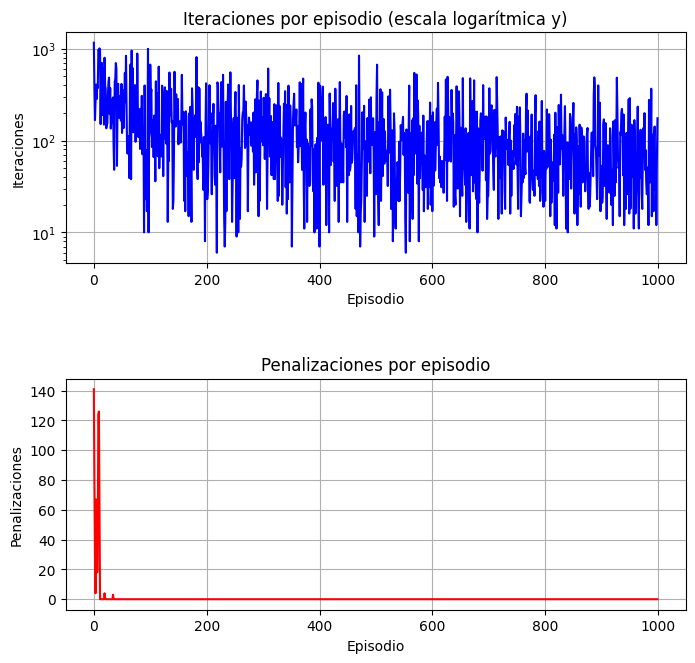

In [24]:
seed_train = 50826476
seed_test = 420
cicles = 20

agente_2 = AgenteRL2(entorno)
num_iteraciones_episodios = []
num_penalizaciones_episodios = []
marcos_episodios = []

x = 0

for i in range(1000):
  if i < 600:
    x = seed_train + i
  else:
    x = seed_test + (i % cicles)
    
  num_iteraciones, penalizaciones, marcos = ejecutar_episodio(agente_2, x)
  agente_2.episodes_iter += [num_iteraciones]
  agente_2.episodes_pen += [penalizaciones]
  agente_2.episodes_frames += [marcos]

metricas(agente_2)

plt.figure(figsize=(8, 12))

_index = [i for i in range(0, len(agente_2.episodes_iter))]

dibujar_subgrafico(
  _index, 
  agente_2.episodes_iter, 
  1, 
  'Iteraciones', 
  'Iteraciones por episodio (escala logarítmica y)',
  escala_log_y=True
)

dibujar_subgrafico(
  _index,
  agente_2.episodes_pen,
  2,
  'Penalizaciones',
  'Penalizaciones por episodio',
  color='red',
)

plt.subplots_adjust(hspace=0.5)
plt.show()

In [25]:
# Ver alguno de los episodios
ver_episodio(agente_2.episodes_frames[600])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iteracion: 17
Estado: 475
Accion: 5
Recompensa: 20


#### Caso de estudio: AgenteRL3.

Este agente tampoco funciona mejor que el `AgenteRL`, pero creemos que actualizar `self.k` con la cantidad de ocurrencias de la tríada (estado, acción, recompensa) es una mejora potencial, dado que el agente va a explotar en base a un contexto específico, y no en base a un numero que simplemente crece con el tiempo.

In [26]:
import numpy as np
import pdb

# Mitchell 97. Chapter 13
class AgenteRL3(AgenteRL):
    def __init__(self, entorno) -> None:
        super().__init__(entorno)
        self.visits = {}
    
    def elegir_accion(self, estado, max_accion) -> int:
        return super().elegir_accion(estado, max_accion)
        
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # Actualizamos la tabla Q con la ecuacion de Bellman 
        Q_max_estado_siguiente = np.max(self.Q[estado_siguiente])
        tupla = (estado_anterior, accion, recompensa)
        
        self.visits.setdefault(tupla, 0)
        self.visits[tupla] += 1
        self.k = self.visits[tupla] 
        
        self.Q[estado_anterior, accion] = recompensa + self.gamma * Q_max_estado_siguiente

In [27]:
seed_train = 50826476
seed_test = 420
cicles = 20

agente_3 = AgenteRL3(entorno)
num_iteraciones_episodios = []
num_penalizaciones_episodios = []
marcos_episodios = []

x = 0

for i in range(1000):
  if i < 600:
    x = seed_train + i
  else:
    x = seed_test + (i % cicles)
    
  num_iteraciones, penalizaciones, marcos = ejecutar_episodio(agente_3, x)
  agente_3.episodes_iter    += [num_iteraciones]
  agente_3.episodes_pen     += [penalizaciones]
  agente_3.episodes_frames  += [marcos]

In [28]:
# Ver alguno de los episodios
ver_episodio(agente_3.episodes_frames[600])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iteracion: 10
Estado: 475
Accion: 5
Recompensa: 20


[AgenteRL3]
  [ITERACIONES]       mean: 33.093, std: 100.92815440202995
  [PENALIZACIONES]    mean: 1.154, std: 13.565186471257961
  
[AgenteRL]
  [ITERACIONES]       mean: 28.625, std: 72.34753883167001
  [PENALIZACIONES]    mean: 0.765, std: 8.518672138308881
  
AgenteRL3 >> AgenteRL : 21.0 %
AgenteRL3 << AgenteRL : 79.0 %


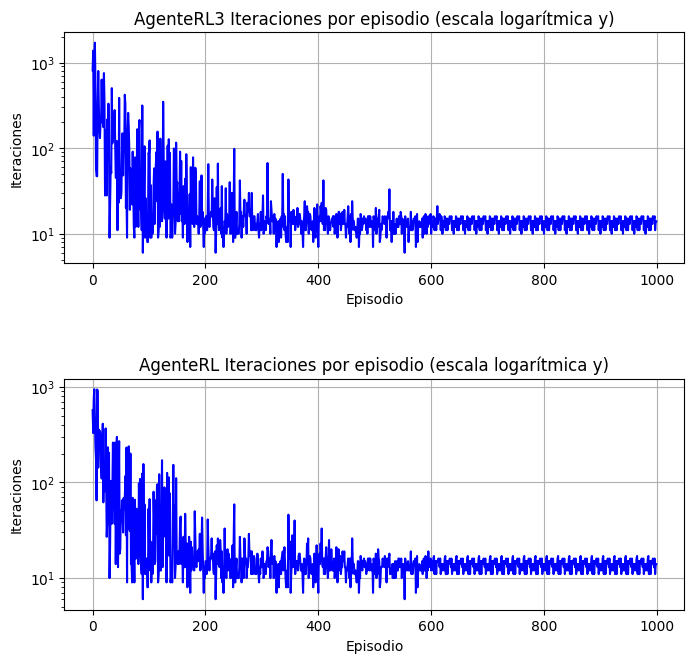

In [29]:
comparar_agentes(agente_3, agente_1)